In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

### Check if cuda is available

In [59]:
torch.cuda.is_available()

True

### Cifar10 dataset 

In [55]:
cifar = load_dataset("cifar10",)
i = cifar["train"]["img"][0]
print(i.size)

(32, 32)


Images in cifar10 has small size 32 x 32 which is faster for training. Moreover, the dataset has 10 classes and we can see that both train and test datasets are balanced with equal number of smaples per class

In [53]:
df_train = pd.DataFrame(cifar["train"])
df_train.groupby(by="label").count()

,img
label,
0,5000
1,5000
2,5000
3,5000
4,5000
5,5000
6,5000
7,5000
8,5000


In [52]:
df_test = pd.DataFrame(cifar["test"])
df_test.groupby(by="label").count()

,img
label,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000


Names of classes

In [58]:
labels = cifar["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
    
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### The Model Architecture

In [4]:
class NaturalSceneClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

### Dataset Class

In [25]:
transform = transforms.Compose([
    # you can add other transformations in this list
     transforms.Resize((32,32)),
    transforms.ToTensor()
])

class Dataset(Dataset):
    
    # Constructor 
    def __init__(self, X_data, Y_data, transform=transform):
        self.len = len(X_data)
        self.x = X_data
        self.y = Y_data
        self.transform = transform
             
    # Getter
    def __getitem__(self, index):
        x = self.x[index] 
        y = self.y[index]
        if self.transform:
            x = self.transform(x)     
        return x, y
    
    # Get Length
    def __len__(self):
        return self.len


In [26]:
dataset_train = Dataset( X_data = cifar["train"]["img"], Y_data = cifar["train"]["label"])
train_loader = DataLoader(dataset=dataset_train, batch_size=128, shuffle=True)
dataset_test = Dataset( X_data = cifar["test"]["img"], Y_data = cifar["test"]["label"])
test_loader = DataLoader(dataset=dataset_test, batch_size=128, shuffle=True)

Preview an image from the dataset

Label : 2


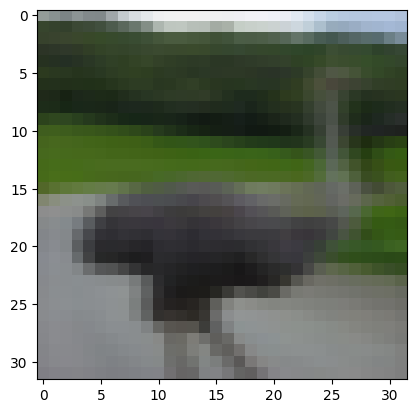

In [39]:
img,label = dataset_train[110]

def display_img(img,label):
    print(f"Label : {label}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(img, label)

Choosing the Optimizer and the Cost function

In [27]:
model = NaturalSceneClassification()
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_new = nn.CrossEntropyLoss()

### Training the model

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



model.train()
for epoch in range(10):

    train_losses = []
    train_acc = []
 
    for x,y in train_loader:

        optimizer.zero_grad()
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_acc.append(acc.item())
        

    print("epoch loss", sum(train_losses)/len(train_losses), "acc", sum(train_acc)/len(train_acc))



epoch loss 1.2422582228165453 acc 0.5449688298927854
epoch loss 1.002661668278677 acc 0.6383751598770356
epoch loss 0.8286447400022345 acc 0.7053148976677214
epoch loss 0.699113958936823 acc 0.7522977941176471
epoch loss 0.585098624305652 acc 0.7917798913043478
epoch loss 0.48789337544185124 acc 0.8274536445317671
epoch loss 0.3894337900459309 acc 0.8626918158567775
epoch loss 0.31607526079620546 acc 0.8888666879795396
epoch loss 0.24061696930690799 acc 0.9149216751918159
epoch loss 0.18771342065213892 acc 0.934099264766859


#### Evaluating the model on the test data

In [43]:
model.eval()
with torch.no_grad():
    
    test_losses = []
    test_acc = []
    
    for x,y in test_loader:
        
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        test_losses.append(loss.item())
        test_acc.append(acc.item())

    print("epoch loss", sum(test_losses)/len(test_losses), "acc", sum(test_acc)/len(test_acc))

epoch loss 0.9411083656021312 acc 0.7643393987341772
